In [ ]:
import numpy as np
import math
from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Conv2D, AveragePooling2D, Flatten, Lambda
from keras.models import Model
import keras.backend as K
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from sklearn.manifold import TSNE
import pylab

In [ ]:
CATEGORIES = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
class LenetData():
  def __init__(self, valid_ratio: float) -> None:
    self.train_x = None
    self.train_y = None
    self.test_x = None
    self.test_y = None
    self.valid_x = None
    self.valid_y = None

    self.load_data()
    self.preprocess_data()
    self.split_valid(valid_ratio)

  def load_data(self) -> None:
    (self.train_x, self.train_y), (self.test_x, self.test_y) = fashion_mnist.load_data()

  def preprocess_data(self) -> None:
    self.train_x = self.train_x / 255.0
    self.test_x = self.test_x / 255.0
    self.train_x = np.array(self.train_x).reshape(-1, 28, 28, 1)
    self.test_x = np.array(self.test_x).reshape(-1, 28, 28, 1)

  def split_valid(self, ratio: float) -> None:
    self.valid_x = self.train_x[:math.floor(self.train_x.shape[0] * ratio)]
    self.valid_y = self.train_y[:math.floor(self.train_y.shape[0] * ratio)]
    self.train_x = self.train_x[:math.floor(self.train_x.shape[0] * (1 - ratio))]
    self.train_y = self.train_y[:math.floor(self.train_y.shape[0] * (1 - ratio))]

  def get_data(self) -> tuple:
    return (self.train_x, self.train_y, self.test_x, self.test_y, self.valid_x, self.valid_y)

In [ ]:
def make_pairs(images, labels):
  pair_images = []
  pair_labels = []

  num_classes = len(np.unique(labels))
  indexes = [np.where(labels == i)[0] for i in range(0, num_classes)]

  for im_index in range(len(images)):
    curr_image = images[im_index]
    label = labels[im_index]

    next_im_index = np.random.choice(indexes[label])
    pos_image = images[next_im_index]

    pair_images.append([curr_image, pos_image])
    pair_labels.append([1])

    neg_indexes = np.where(labels != label)[0]
    neg_image = images[np.random.choice(neg_indexes)]

    pair_images.append([curr_image, neg_image])
    pair_labels.append([0])

  return (np.array(pair_images), np.array(pair_labels).astype('float32'))

In [ ]:
def check_equality(model, image_pair, image_index):
  image_first = image_pair[image_index][0].reshape(1, 28, 28, 1)
  image_second = image_pair[image_index][1].reshape(1, 28, 28, 1)

  predicted_value = model.predict([image_first, image_second])[0]

  sp = plt.subplot(1, 2, 1)
  plt.imshow(image_pair[image_index][0])
  sp = plt.subplot(1, 2, 2)
  plt.imshow(image_pair[image_index][1])
  
  figtext_kwargs = {
      "horizontalalignment": "center",
      "fontsize": 14,
      "color": "green",
      "wrap": True
  }
  
  if predicted_value < 0.5:
    figtext_kwargs["color"] = "green"
  else:
    figtext_kwargs["color"] = "red"

  plt.figtext(0.5, 0, predicted_value, **figtext_kwargs)  
  plt.show()

In [ ]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(sum_square)

In [ ]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [ ]:
def build_siamese_model():
  input_layer = Input((28, 28, 1))
  layer1 = Conv2D(6, kernel_size=5, strides=1, activation='tanh', padding='same')(input_layer)
  layer2 = AveragePooling2D()(layer1)
  layer3 = Conv2D(16, kernel_size=5, strides=1, activation='tanh', padding='valid')(layer2)
  layer4 = AveragePooling2D()(layer3)
  layer5 = Conv2D(120, kernel_size=5, strides=1, activation='tanh', padding='valid')(layer4)
  layer6 = Flatten()(layer5)
  layer7 = Dense(84, activation='tanh')(layer6)
  output_layer = Dense(10, activation='softmax')(layer7)

  model = Model(input_layer, output_layer)

  return model

In [ ]:
def accuracy(pred_val, true_val):
  matches_count = np.array(np.where(np.logical_and(pred_val < 0.5, true_val == 1.0))).size
  acc = (matches_count * 100.0) / (pred_val.size)
  return "Accuracy: {}%".format(acc)

In [ ]:
lenet = LenetData(valid_ratio=0.1)
train_x, train_y, test_x, test_y, valid_x, valid_y = lenet.get_data()

In [ ]:
pair_train_x, pair_train_y = make_pairs(train_x, train_y)
pair_valid_x, pair_valid_y = make_pairs(valid_x, valid_y)
pair_test_x, pair_test_y = make_pairs(test_x, test_y)

In [ ]:
base_model_5 = build_siamese_model()

In [ ]:
input_left = Input(shape=(28, 28, 1))
vect_output_left = base_model_5(input_left)

input_right = Input(shape=(28, 28, 1))
vect_output_right = base_model_5(input_right)

output = Lambda(euclidean_distance)([vect_output_left, vect_output_right])

model_5 = Model([input_left, input_right], output)

In [ ]:
rms = RMSprop()
model_5.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model_5.fit(
    [pair_train_x[:,0], pair_train_x[:,1]], 
    pair_train_y,
    epochs=5, 
    batch_size=32, 
    validation_data = ([pair_valid_x[:, 0], pair_valid_x[:, 1]], pair_valid_y))

Epoch 1/5
3375/3375 [==============================] - 31s 6ms/step - loss: 0.0993 - val_loss: 0.0817
Epoch 2/5
3375/3375 [==============================] - 20s 6ms/step - loss: 0.0757 - val_loss: 0.0688
Epoch 3/5
3375/3375 [==============================] - 21s 6ms/step - loss: 0.0676 - val_loss: 0.0653
Epoch 4/5
3375/3375 [==============================] - 21s 6ms/step - loss: 0.0615 - val_loss: 0.0581
Epoch 5/5
3375/3375 [==============================] - 27s 8ms/step - loss: 0.0577 - val_loss: 0.0579


In [ ]:
base_model_25 = build_siamese_model()

input_left = Input(shape=(28, 28, 1))
vect_output_left = base_model_25(input_left)

input_right = Input(shape=(28, 28, 1))
vect_output_right = base_model_25(input_right)

output = Lambda(euclidean_distance)([vect_output_left, vect_output_right])

model_25 = Model([input_left, input_right], output)


rms = RMSprop()
model_25.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model_25.fit(
    [pair_train_x[:,0], pair_train_x[:,1]], 
    pair_train_y,
    epochs=25, 
    batch_size=32, 
    validation_data = ([pair_valid_x[:, 0], pair_valid_x[:, 1]], pair_valid_y))

Epoch 1/25
3375/3375 [==============================] - 23s 6ms/step - loss: 0.0987 - val_loss: 0.0838
Epoch 2/25
3375/3375 [==============================] - 22s 6ms/step - loss: 0.0768 - val_loss: 0.0720
Epoch 3/25
3375/3375 [==============================] - 21s 6ms/step - loss: 0.0695 - val_loss: 0.0635
Epoch 4/25
3375/3375 [==============================] - 21s 6ms/step - loss: 0.0644 - val_loss: 0.0602
Epoch 5/25
3375/3375 [==============================] - 21s 6ms/step - loss: 0.0609 - val_loss: 0.0586
Epoch 6/25
3375/3375 [==============================] - 20s 6ms/step - loss: 0.0581 - val_loss: 0.0570
Epoch 7/25
3375/3375 [==============================] - 21s 6ms/step - loss: 0.0556 - val_loss: 0.0570
Epoch 8/25
3375/3375 [==============================] - 21s 6ms/step - loss: 0.0536 - val_loss: 0.0516
Epoch 9/25
3375/3375 [==============================] - 21s 6ms/step - loss: 0.0517 - val_loss: 0.0520
Epoch 10/25
3375/3375 [==============================] - 21s 6ms/step - l

In [ ]:
pred_train_y = model_5.predict([pair_train_x[:,0], pair_train_x[:,1]])
pred_train_acc = accuracy(pred_train_y, pair_train_y)

pred_test_y = model_5.predict([pair_test_x[:,0], pair_test_x[:,1]])
pred_test_acc = accuracy(pred_test_y, pair_test_y)

print("Train data {}, Test data {}".format(pred_train_acc, pred_test_acc))

625/625 [==============================] - 2s 3ms/step
Train data Accuracy: 93.99814814814815%, Test data Accuracy: 90.94%


In [ ]:
pred_train_y = model_25.predict([pair_train_x[:,0], pair_train_x[:,1]])
pred_train_acc = accuracy(pred_train_y, pair_train_y)

pred_test_y = model_25.predict([pair_test_x[:,0], pair_test_x[:,1]])
pred_test_acc = accuracy(pred_test_y, pair_test_y)

print("Train data {}, Test data {}".format(pred_train_acc, pred_test_acc))

625/625 [==============================] - 3s 5ms/step
Train data Accuracy: 97.42037037037036%, Test data Accuracy: 89.67%


1/1 [==============================] - 0s 392ms/step


/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


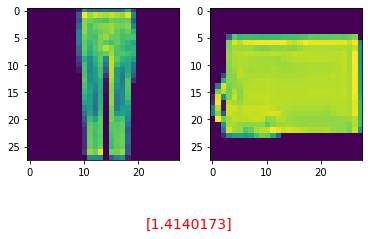

In [ ]:
check_equality(model_25, pair_valid_x, 3433)

In [ ]:
feature_model = base_model_25

In [ ]:
x_test_features = base_model_25.predict(train_x)

1688/1688 [==============================] - 5s 3ms/step


In [ ]:
tsne_1000 = TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=1000,
                         n_iter_without_progress=100,
                         verbose=2)
tsne_1000_features = tsne_1000.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 54000 samples in 0.074s...
[t-SNE] Computed neighbors for 54000 samples in 2.631s...
[t-SNE] Computed conditional probabilities for sample 1000 / 54000
[t-SNE] Computed conditional probabilities for sample 2000 / 54000
[t-SNE] Computed conditional probabilities for sample 3000 / 54000
[t-SNE] Computed conditional probabilities for sample 4000 / 54000
[t-SNE] Computed conditional probabilities for sample 5000 / 54000
[t-SNE] Computed conditional probabilities for sample 6000 / 54000
[t-SNE] Computed conditional probabilities for sample 7000 / 54000
[t-SNE] Computed conditional probabilities for sample 8000 / 54000
[t-SNE] Computed conditional probabilities for sample 9000 / 54000
[t-SNE] Computed conditional probabilities for sample 10000 / 54000
[t-SNE] Computed conditional probabilities for sample 11000 / 54000
[t-SNE] Computed conditional probabilities for sample 12000 / 54000
[t-SNE] Computed conditional probabilities for sam

In [ ]:
tsne_3 = TSNE(n_components=3,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=1000,
                         n_iter_without_progress=100,
                         verbose=2)
tsne_3_features = tsne_3.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 54000 samples in 0.078s...
[t-SNE] Computed neighbors for 54000 samples in 2.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 54000
[t-SNE] Computed conditional probabilities for sample 2000 / 54000
[t-SNE] Computed conditional probabilities for sample 3000 / 54000
[t-SNE] Computed conditional probabilities for sample 4000 / 54000
[t-SNE] Computed conditional probabilities for sample 5000 / 54000
[t-SNE] Computed conditional probabilities for sample 6000 / 54000
[t-SNE] Computed conditional probabilities for sample 7000 / 54000
[t-SNE] Computed conditional probabilities for sample 8000 / 54000
[t-SNE] Computed conditional probabilities for sample 9000 / 54000
[t-SNE] Computed conditional probabilities for sample 10000 / 54000
[t-SNE] Computed conditional probabilities for sample 11000 / 54000
[t-SNE] Computed conditional probabilities for sample 12000 / 54000
[t-SNE] Computed conditional probabilities for sam

In [ ]:
def tsne_visualisation(tsne_features):
  if tsne_features.shape[1] == 2:
    colors = plt.cm.rainbow(np.linspace(0, 1, 10))
    plt.figure(figsize=(10, 10))

    for group_index, (group_color, group_label) in enumerate(zip(colors, CATEGORIES)):
        plt.scatter(tsne_500_features[np.where(train_y == group_index), 0],
                    tsne_500_features[np.where(train_y == group_index), 1],
                    marker='o',
                    color=group_color,
                    alpha=0.8,
                    label=group_label)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('t-SNE')
    plt.legend(loc='best')
    plt.show(block=False)
  elif tsne_features.shape[1] == 3:
    fig = plt.figure(figsize=(20,12))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(tsne_3_features[:, 0], tsne_3_features[:, 1],tsne_3_features[:,2], s=5, c=train_y, cmap='Spectral')
    plt.title('t-SNE in 3D');
    plt.show()

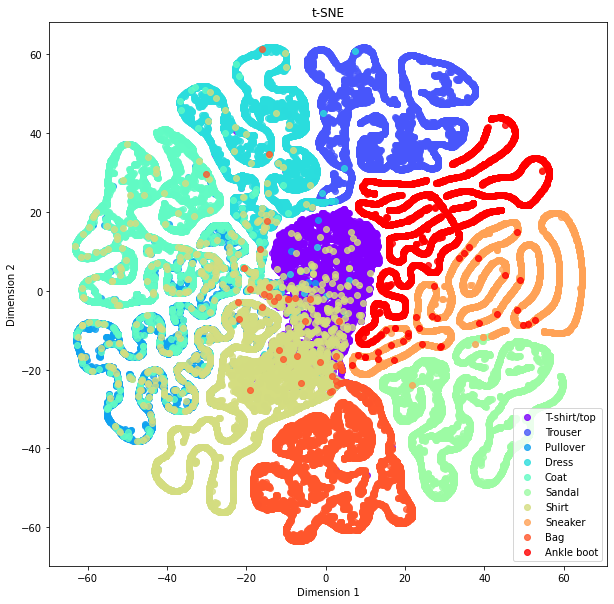

In [ ]:
tsne_visualisation(tsne_1000_features)

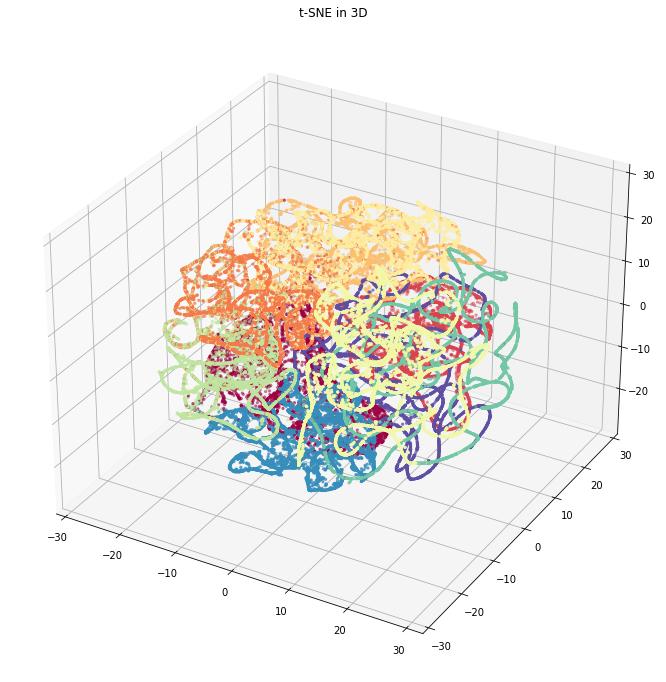

In [ ]:
tsne_visualisation(tsne_3_features)